Datos reales de ratings entre usuarios-objetos

-> Archivo .csv

-> Debe tener exactamente  las columnas: ['userId', 'itemId', 'rating']

-> userId e itemId deben ser identificadores (enteros) que puedan usarse como índices. rating debe ser numérico (float o int). [int64, int64, float64]

-> No debe haber NaN en ninguna de las tres columnas

-> Un valor de Rating de 0 no podrá usarse porque en las implementaciones significará la ausencia de rating entre usuario-objeto

-> No debería haber pares (userId, itemId) repetidos

In [ ]:
# MovieLens 1M Dataset
# ml-1m .dat to .csv

#  Abrir archivo de entrada y salida
with open("../Datasets/ml-1m/ratings.dat", "r") as infile, open("../Datasets/ml-1m.csv", "w") as outfile:
    # Escribir encabezados
    outfile.write("userId,itemId,rating\n")
    
    # Procesar cada línea
    for line in infile:
        partes = line.strip().split("::")
        if len(partes) == 4:
            user_id, movie_id, rating = partes[:3]  # Ignora timestamp
            rating_float = float(rating)  # Convertir rating a float
            outfile.write(f"{user_id},{movie_id},{rating_float}\n")


In [ ]:
# Amazon Video Games 5-core reviews
# Convert 5-core reviews from jsonl.gz to csv

import gzip
import json
import pandas as pd

def parse_reviews_jsonl_gz(path):
    """
    Generator that yields one review dict per line from a .json.gz file.
    """
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for line in f:
            yield json.loads(line)

def build_rating_dataframe(input_path):
    """
    Reads the JSONL gzip, extracts reviewerID, asin, overall,
    drops duplicate (userId, itemId) pairs, factorizes IDs,
    and returns a pandas DataFrame.
    """
    records = []
    for review in parse_reviews_jsonl_gz(input_path):
        records.append({
            'userId': review['reviewerID'],
            'itemId': review['asin'],
            'rating': review['overall']
        })
    df = pd.DataFrame(records, columns=['userId', 'itemId', 'rating'])

    # --- DROP DUPLICATES ---
    # Keep only the last review if a user rated the same item multiple times
    df = df.drop_duplicates(subset=['userId', 'itemId'], keep='last')

    # Factorize to numeric IDs (0, 1, 2, …)
    df['userId'] = pd.factorize(df['userId'])[0] + 1
    df['itemId'] = pd.factorize(df['itemId'])[0] + 1

    return df

def main():
    input_path  = '../Datasets/Video_Games_5.json.gz'   # change to your file
    output_path = '../Datasets/ratingsVG.csv'

    print(f"Reading from {input_path} …")
    df = build_rating_dataframe(input_path)
    print(f"Read {len(df):,} rows. Writing to {output_path} …")
    print(f"Writing to {output_path} …")
    df.to_csv(output_path, index=False)
    print("Done.")

if __name__ == '__main__':
    main()

Reading from ../Datasets/Video_Games_5.json.gz …
Read 473,427 rows. Writing to ../Datasets/ratingsVG.csv …
Writing to ../Datasets/ratingsVG.csv …
Done.


In [ ]:
# Jester Dataset
# Convert Jester dataset from .zip to .csv

import os
import zipfile
import pandas as pd

# List of dataset zip files
zip_files = [
    '../Datasets/jester_dataset_1_1.zip',
    '../Datasets/jester_dataset_1_2.zip',
    '../Datasets/jester_dataset_1_3.zip'
]

# Output CSV file
output_csv = '../Datasets/jester.csv'

# Initialize list to collect DataFrames
dfs = []

# Loop over each zip file
for zip_path in zip_files:
    # Extract the .xls file name
    with zipfile.ZipFile(zip_path, 'r') as z:
        xls_name = [f for f in z.namelist() if f.endswith('.xls')][0]
        # Read the Excel file into a DataFrame
        with z.open(xls_name) as xls_file:
            df = pd.read_excel(xls_file, header=None)

    # The first column is the number of jokes rated (we can drop it)
    df = df.drop(columns=[0])

    # Rename rating columns to item IDs 1-100
    df.columns = [i for i in range(1, 101)]

    # Create userId based on cumulative index
    # To ensure unique user IDs across files, offset by the total seen so far
    start_id = sum(d.shape[0] for d in dfs)
    df = df.reset_index(drop=True)
    df['userId'] = df.index + 1 + start_id

    # Melt to long format: userId, itemId, rating
    long_df = df.melt(id_vars='userId', var_name='itemId', value_name='rating')

    # Filter out missing ratings (coded as 99)
    long_df = long_df[long_df['rating'] != 99]

    # Ensure correct dtypes
    long_df = long_df.astype({
        'userId': 'int64',
        'itemId': 'int64',
        'rating': 'float64'
    })

    # Append to list
    dfs.append(long_df)



# Concatenate all DataFrames
result = pd.concat(dfs, ignore_index=True)

# add 10 to rating to match Jester's 0-10 scale
result['rating'] = result['rating'] #+ 10

# Drop duplicates if any (userId, itemId pairs)
result = result.drop_duplicates(subset=['userId', 'itemId'])

# Randomly select 10000 unique users
top_n = 10000
unique_users = result['userId'].drop_duplicates()
# For reproducibility, you can set a random seed
default_seed = 42  # e.g., 42
random_users = unique_users.sample(n=top_n, replace=False, random_state=default_seed)

# Filter result to include only those random users
result = result[result['userId'].isin(random_users)]

# Save to CSV without the index
result.to_csv(output_csv, index=False)

print(f"Saved {len(result)} ratings to {output_csv}")


Saved 562681 ratings to ../Datasets/jester.csv


In [ ]:
# Sushi Dataset


import pandas as pd

# 1. Read the space‐separated score matrix (no header, 5000 rows × 100 cols)
df = pd.read_csv('../Datasets/sushi3b.5000.10.score', sep=' ', header=None, dtype=float)

# 2. Assign userId and itemId
#    - userId: the row number (0-based or 1-based; here we use 0-based)
#    - itemId: the column number (0–99)
df.index.name = 'userId'
df.columns.name = 'itemId'

# 3. Unpivot (melt) to long form
long = df.reset_index().melt(id_vars='userId',
                             var_name='itemId',
                             value_name='rating')

# 4. Drop unrated entries (-1) and ensure correct types
long = long[long['rating'] >= 0].copy()

# 5. Sumar 1 a todas las puntuaciones
long['rating'] = long['rating'] + 1

long['userId']   = long['userId'].astype('int64')
long['itemId']   = long['itemId'].astype('int64')
long['rating']   = long['rating'].astype('float64')

# 5. Sanity checks
assert not long.isnull().any().any(), "Found NaNs!"
assert long.duplicated(subset=['userId','itemId']).sum() == 0, "Duplicates found!"

# 6. Write to CSV
long.to_csv('../Datasets/sushi_ratings.csv', index=False, columns=['userId','itemId','rating'])


In [1]:
import pandas as pd

# Cargar el archivo
df = pd.read_csv('../Datasets/Ratings.csv', sep=None, engine='python')

# Renombrar columnas
df.columns = ['userId', 'itemId', 'rating']

# Eliminar ratings con valor 0
df = df[df['rating'] != 0]

# Filtrar usuarios con al menos 10 ratings
user_counts = df['userId'].value_counts()
valid_users = user_counts[user_counts >= 10].index
df = df[df['userId'].isin(valid_users)]

# Filtrar libros con más de 10 ratings
item_counts = df['itemId'].value_counts()
valid_items = item_counts[item_counts >= 10].index
df = df[df['itemId'].isin(valid_items)]

# Reasignar IDs únicos a usuarios e items (empezando desde 1)
user_mapping = {old: new for new, old in enumerate(df['userId'].unique(), start=1)}
item_mapping = {old: new for new, old in enumerate(df['itemId'].unique(), start=1)}

df['userId'] = df['userId'].map(user_mapping)
df['itemId'] = df['itemId'].map(item_mapping)

# Asegurar que el rating sea float64
df['rating'] = df['rating'].astype('float64')

# Guardar resultado
df.to_csv('../Datasets/books.csv', index=False)


In [33]:
# syn

import pandas as pd

# Leer el archivo .txt
df = pd.read_csv('synthetic_150000_500_500.txt')

# Renombrar las columnas
df.rename(columns={'user': 'userId', 'item': 'itemId'}, inplace=True)

# Guardar como .csv
df.to_csv('../Datasets/syn.csv', index=False)

print("Archivo 'ratings.csv' creado con éxito.")


Archivo 'ratings.csv' creado con éxito.


Columnas: ['userId', 'itemId', 'rating']

Nulos por columna:
 userId    0
itemId    0
rating    0
dtype: int64

userId      int64
itemId      int64
rating    float64
dtype: object

Rating mínimo: 0.5, máximo: 5.0

Pares (userId,itemId) duplicados: 0

#Usuarios: 432, #Items: 1060, #Ratings: 1319
Density: 0.2880

Media de ratings: 3.42, Desviación estándar: 0.92

Número de celdas en la matriz de ratings: 457,920


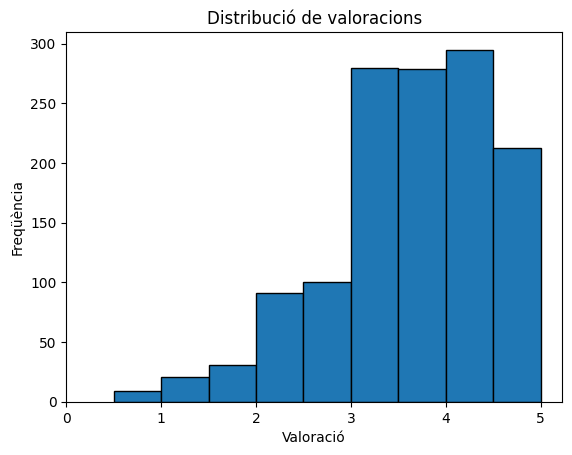

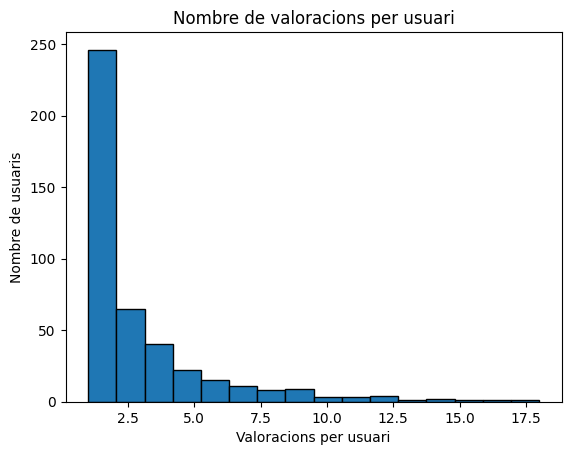

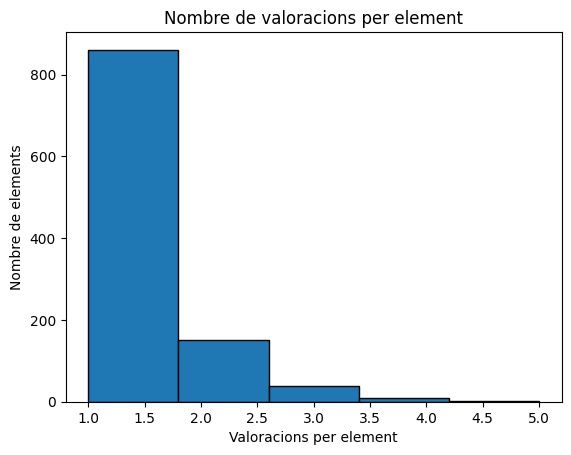

In [25]:
#
# Exploratory Data Analysis (EDA)


import pandas as pd
import matplotlib.pyplot as plt

path = '../Datasets/'
ratings = pd.read_csv(path + 'syn03.csv')

# 1. Columnas
print("Columnas:", ratings.columns.tolist())
print()

# 2. Nulos
print("Nulos por columna:\n", ratings.isnull().sum())
print()

# 4. Tipos
print(ratings.dtypes)
print()

# 5. Rango de ratings
min_r, max_r = ratings['rating'].min(), ratings['rating'].max()
print(f"Rating mínimo: {min_r}, máximo: {max_r}")
print()

# 6. Duplicados
dups = ratings.duplicated(subset=['userId','itemId']).sum()
print(f"Pares (userId,itemId) duplicados: {dups}")
print()

# 7. Volumen y sparsity
n_users = ratings['userId'].nunique()
n_items = ratings['itemId'].nunique()
n_ratings = len(ratings)
density = n_ratings / (n_users * n_items) * 100
print(f"#Usuarios: {n_users}, #Items: {n_items}, #Ratings: {n_ratings}")
print(f"Density: {density:.4f}")
print()

# 8. Media y desviación estándar de ratings
mean_rating = ratings['rating'].mean()
std_rating = ratings['rating'].std()
print(f"Media de ratings: {mean_rating:.2f}, Desviación estándar: {std_rating:.2f}")
print()

# 9. Número de celdas en una matriz de ratings
n_cells = n_users * n_items
print(f"Número de celdas en la matriz de ratings: {n_cells:,}")

# 1. Histograma de ratings
plt.figure()
plt.hist(ratings['rating'], bins=9, edgecolor='black')
plt.title('Distribució de valoracions')
plt.xlabel('Valoració')
plt.ylabel('Freqüència')
plt.xticks([0, 1, 2, 3, 4, 5])
#plt.savefig('../Memoria/Figuras/syn03-ratings.png') 
plt.show()

# 2. Distribución de interacciones por usuario
user_counts = ratings.groupby('userId').size()
plt.figure()
plt.hist(user_counts, bins=16, edgecolor='black')
plt.title('Nombre de valoracions per usuari')
plt.xlabel('Valoracions per usuari')
plt.ylabel('Nombre de usuaris')
#plt.savefig('../Memoria/Figuras/syn03-users.png') 
plt.show()

# 3. Distribución de interacciones por ítem
item_counts = ratings.groupby('itemId').size()
plt.figure()
plt.hist(item_counts, bins=5, edgecolor='black')
plt.title('Nombre de valoracions per element')
plt.xlabel('Valoracions per element')
plt.ylabel('Nombre de elements')
#plt.savefig('../Memoria/Figuras/syn03-items.png') 
plt.show()



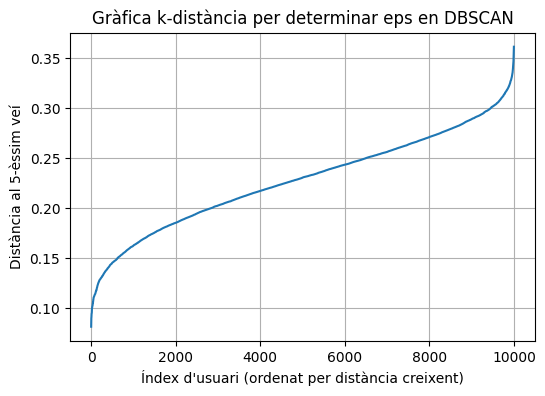

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def similarity(train_df):
    user_item = train_df.pivot_table(index='userId', columns='itemId', values='rating')

    R = user_item.values
    mask = ~np.isnan(R)

    # Media de valoraciones por usuario
    sums = np.nansum(R, axis=1)
    counts = mask.sum(axis=1)
    means = sums / counts

    # Restar la media
    R_centered = (R - means[:, None]) * mask
    R_centered[np.isnan(R_centered)] = 0

    # Producto punto entre usuarios
    norms = np.linalg.norm(R_centered, axis=1)
    numerator = R_centered.dot(R_centered.T)

    # Producto de las normas de los vectores
    denominator = norms[:, None] * norms[None, :]

    # Pearson
    sim = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0)

    return pd.DataFrame(sim, index=user_item.index, columns=user_item.index), R_centered, means, user_item


dataset = 'jester'
min_samples = 5  # por ejemplo

# 1) Carga tus datos y completa NaNs con la media por usuario:
ratings = pd.read_csv(f'../Datasets/{dataset}.csv')
sim, _, _, _ = similarity(ratings)
sim = sim.values.copy()
sim = np.clip(sim, -1.0, 1.0)
dist = (1 - sim) / 2.0

# 3) Calcula la distancia al k-ésimo vecino (k = min_samples):

nbrs = NearestNeighbors(n_neighbors=min_samples, metric='precomputed').fit(dist)
distances, _ = nbrs.kneighbors(dist)

# distances[i,j] es la distancia del punto i a su j-ésimo vecino.
# Tomamos la columna k-1 (índice min_samples-1) y la ordenamos:
k_distances = np.sort(distances[:, min_samples-1])

# 4) Grafica la curva k-distancia:
plt.figure(figsize=(6,4))
plt.plot(k_distances)
plt.xlabel("Índex d'usuari (ordenat per distància creixent)")
plt.ylabel(f"Distància al {min_samples}-èssim veí")
plt.title("Gràfica k-distància per determinar eps en DBSCAN")
plt.grid(True)
plt.savefig(f'../Memoria/Figuras/DBSCAN/k-distancia-pearson-{dataset}-{min_samples}.png')
plt.show()


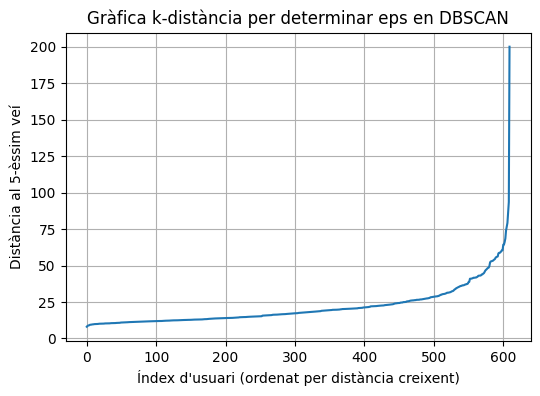

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# 1) Carga tus datos y crea la matriz usuario×item:
dataset = 'ml-small'
min_samples = 5
ratings = pd.read_csv(f'../Datasets/{dataset}.csv')
user_item = ratings.pivot_table(index='userId', columns='itemId', values='rating')

# 2) Imputación de NaNs con la media de cada usuario
filled = user_item.values.copy()
user_means = np.nanmean(filled, axis=1, keepdims=True)  # media de cada fila (usuario)
# donde haya NaN, reemplaza por la media del usuario correspondiente
nan_locs = np.isnan(filled)
filled[nan_locs] = np.take(user_means, np.where(nan_locs)[0])

# 3) Estandarizar características (items)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(filled)

# 4) Calcular distancias al k-ésimo vecino (k = min_samples)
nbrs = NearestNeighbors(n_neighbors=min_samples, metric='euclidean')
nbrs.fit(data_scaled)                         # ajusta sobre el espacio de usuarios escalados
distances, indices = nbrs.kneighbors(data_scaled)
# distances[i, j] = distancia del usuario i a su j-ésimo vecino (j desde 0 hasta k-1)

# 5) Tomar la columna correspondiente al k-ésimo vecino (índice k-1):
k_distances = np.sort(distances[:, min_samples - 1])

# 6) Graficar la curva k-distancia
plt.figure(figsize=(6, 4))
plt.plot(k_distances, linewidth=1.5)
plt.xlabel("Índex d'usuari (ordenat per distància creixent)")
plt.ylabel(f"Distància al {min_samples}-èssim veí")
plt.title("Gràfica k-distància per determinar eps en DBSCAN")
plt.grid(True)
#plt.savefig(f'../Memoria/Figuras/DBSCAN/k-distancia-{dataset}-{min_samples}.png')
plt.show()
